In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as np
import jax
from jax import random
key = random.PRNGKey(1)  # For seeding random numbers in JAX
# from jax.config import config
# config.update("jax_enable_x64", True)  # needed to switch from float32 to float64

In [4]:
import torch
import torch.nn as nn

/home/robby/anaconda3/envs/dorl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
%matplotlib inline
import math
from tqdm import tqdm
import argparse
import os
import numpy as onp  # "Old" numpy
import matplotlib
import matplotlib.image
import matplotlib.pyplot
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import collections as mc
from matplotlib import rcParams, ticker, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

rcParams['animation.html'] = 'jshtml'  # Makes the default animation an interactive video
rcParams['animation.embed_limit'] = 2**128  # Allow bigger animations
plt.style.use('seaborn-talk')  # also try 'seaborn-paper', 'fivethirtyeight'

In [6]:
from utils.metrics import get_discretized_tv_for_image_density
from utils.density import continuous_energy_from_image, prepare_image, sample_from_image_density, continuous_density_from_image
from utils.utils import viz_trajectories, vector_field, contour
from utils.flows import PlanarFlow, NormalizingFlow, train, plot_flow_density, plot_exact_density, gaussian_log_pdf, density_from_grid
from utils.hmc import hamiltonian_monte_carlo
import NPEET.npeet.entropy_estimators

### Visualize image

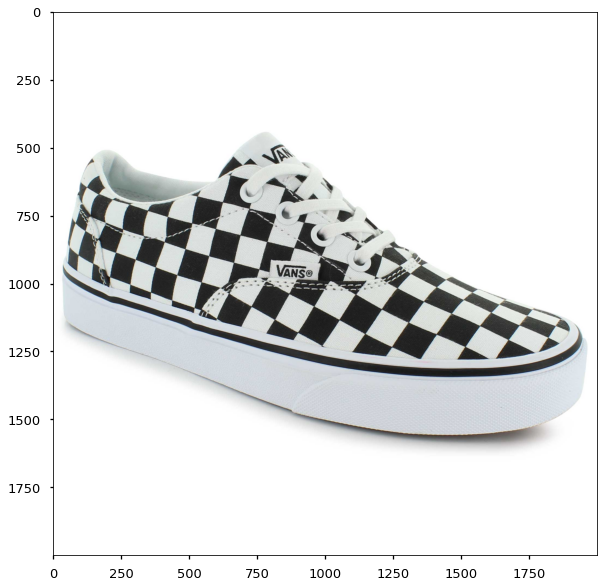

In [7]:
result_folder = "results"
image = "shoe.jpeg"; crop = (0, 2000, 0, 2000)
(image_name, image_type) = image.split(".")

key = jax.random.PRNGKey(0)  # reset JAX random number seed
os.makedirs(f"{result_folder}", exist_ok=True)

# load some image
img = matplotlib.image.imread(f"./data/{image_name}.{image_type}")

# plot and visualize
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
matplotlib.pyplot.show()

### Create density and energy from image

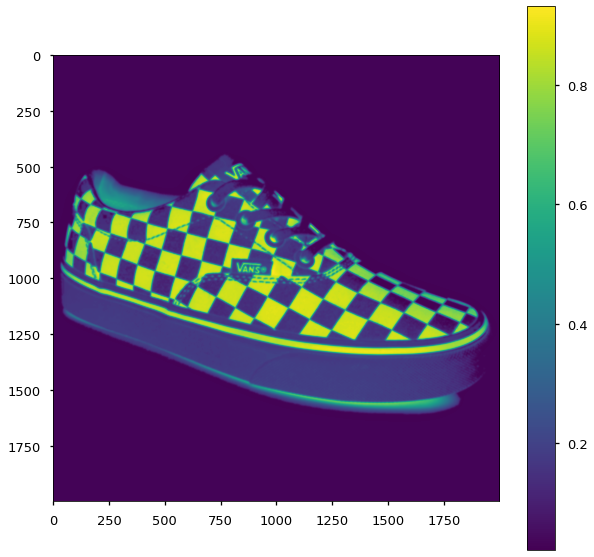

In [8]:
# convert to energy function
# first we get discrete energy and density values
density, energy = prepare_image(
    img, crop=crop, white_cutoff=225, gauss_sigma=3, background=0.01
)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
plot = ax.imshow(density)
fig.colorbar(plot)
matplotlib.pyplot.show()
fig.savefig(f"{result_folder}/{image_name}_density.png")

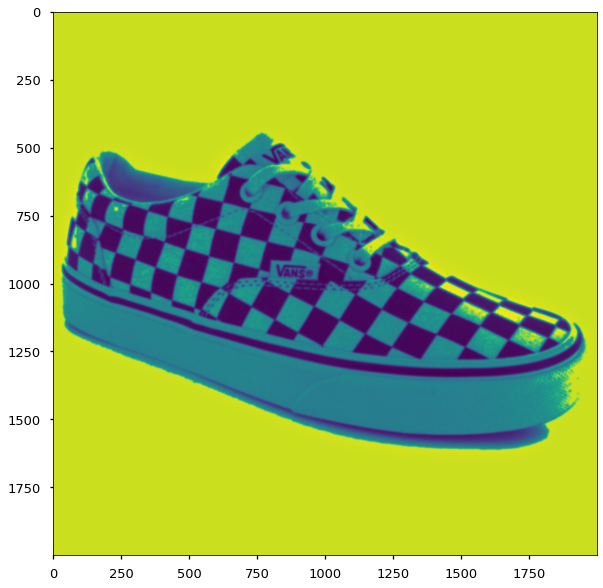

In [9]:
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(energy)
matplotlib.pyplot.show()
fig.savefig(f"{result_folder}/{image_name}_energy.png")

### Create energy function and gradient

In [10]:
# create energy fn and its grad
x_max, y_max = density.shape
xp = jax.numpy.arange(x_max)
yp = jax.numpy.arange(y_max)
zp = jax.numpy.array(density)

# You may use fill value to enforce some boundary conditions or some other way to enforce boundary conditions
energy_fn = lambda coord: continuous_energy_from_image(coord, xp, yp, zp, fill_value=0)
density_fn = lambda coord: continuous_density_from_image(coord, xp, yp, zp, fill_value=0)
energy_fn_grad = jax.grad(energy_fn)

### Random sampling

[[1245.0349     645.035    ]
 [ 835.3477     312.75742  ]
 [ 845.10986    229.99495  ]
 ...
 [ 969.5627     698.14716  ]
 [   4.1777344 1601.206    ]
 [ 916.53015    998.751    ]]


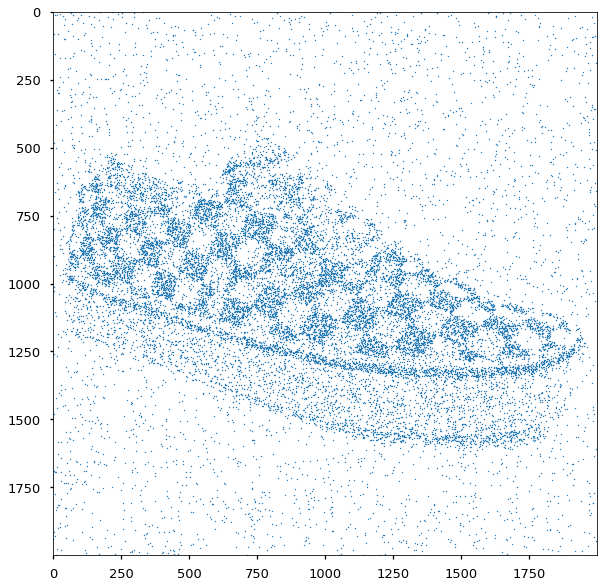

In [22]:
# NOTE: JAX makes it easy to compute fn and its grad, but you can use any other framework.
num_samples = 20_000

# generate samples from true distribution
key, subkey = jax.random.split(key)
samples = sample_from_image_density(num_samples, density, subkey)
print(samples)

# (scatter) plot the samples with image in background
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(onp.array(samples)[:, 1], onp.array(samples)[:, 0], s=1.0, alpha=1.0)
ax.imshow(density, alpha=0.0)
matplotlib.pyplot.show()
fig.savefig(f"{result_folder}/{image_name}_sampled.png")

In [12]:
# generate another set of samples from true distribution, to demonstrate comparisons
key, subkey = jax.random.split(key)
second_samples = sample_from_image_density(num_samples, density, subkey)

# We have samples from two distributions. We use NPEET package to compute kldiv directly from samples.
# NPEET needs nxd tensors
kldiv = NPEET.npeet.entropy_estimators.kldiv(samples, second_samples)
print(f"KL divergence is {kldiv}")

# TV distance between discretized density
# The discrete density bin from the image give us a natural scale for discretization.
# We compute discrete density from sample at this scale and compute the TV distance between the two densities
tv_dist = get_discretized_tv_for_image_density(
    onp.asarray(density), onp.asarray(samples), bin_size=[7, 7]
)
print(f"TV distance is {tv_dist}")

KL divergence is -0.0011554237761207398
TV distance is 0.7567018255973882


### Hamiltonian monte-carlo sampling

In [23]:
potential = energy_fn
d = 2  # dimensionality 
n_iter = 20_000
k = 1

epsilon = 30
# x = random.normal(key, (d,))  # x, position
# x = random.uniform(key, (d,), minval=0, maxval=550)
x = np.array((1000., 1000.))
print(x)
trajectories = onp.zeros((1, n_iter, 2), dtype=x.dtype)  

for i in tqdm(range(n_iter)):
    x = hamiltonian_monte_carlo(x, potential, k, epsilon)
    trajectories[0,i] = x

[1000. 1000.]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [1:20:06<00:00,  4.16it/s]


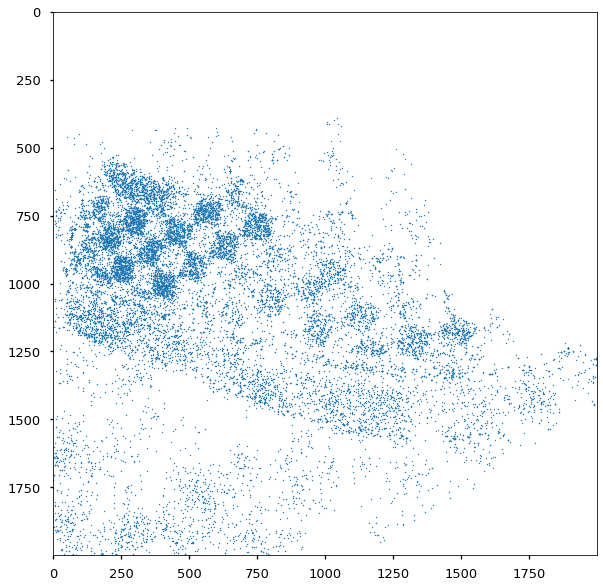

In [24]:
# Plot samples
# (scatter) plot the samples with image in background
samples = trajectories[0]
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(onp.array(samples)[:, 1], onp.array(samples)[:, 0], s=1, alpha=1)
ax.imshow(density, alpha=0.0)
matplotlib.pyplot.show()
fig.savefig(f"{result_folder}/{image_name}_hmc_sampled.png")

In [27]:
print(samples)

[[ 964.7648  1023.76013]
 [1003.02484 1064.5338 ]
 [1003.02484 1064.5338 ]
 ...
 [1046.0896   824.35547]
 [1046.0896   824.35547]
 [1038.5459   839.4178 ]]


In [26]:
# generate another set of samples from true distribution, to demonstrate comparisons
key, subkey = jax.random.split(key)
second_samples = sample_from_image_density(num_samples, density, subkey)

print(second_samples)

# We have samples from two distributions. We use NPEET package to compute kldiv directly from samples.
# NPEET needs nxd tensors
kldiv = NPEET.npeet.entropy_estimators.kldiv(samples, second_samples)
print(f"KL divergence is {kldiv}")

# TV distance between discretized density
# The discrete density bin from the image give us a natural scale for discretization.
# We compute discrete density from sample at this scale and compute the TV distance between the two densities
tv_dist = get_discretized_tv_for_image_density(
    onp.asarray(density), onp.asarray(samples), bin_size=[7, 7]
)
print(f"TV distance is {tv_dist}")

[[1452.055   1479.1436 ]
 [1218.4335  1276.5238 ]
 [1122.3258   682.60614]
 ...
 [1170.4003   467.5399 ]
 [1105.639   1147.7906 ]
 [1158.8767  1681.7635 ]]
KL divergence is inf


/home/robby/repos/cs699_dynamics_of_representation_learning/sampling/NPEET/npeet/entropy_estimators.py:118: RuntimeWarning: divide by zero encountered in log
  return (const + d * (np.log(nnp).mean() - np.log(nn).mean())) / log(base)


TV distance is 1.3699147438330155


In [16]:
# Visualize trajectories
ani4 = viz_trajectories(trajectories, decay=0.95, image=density)
ani4  # Show it

Formatting data...
Creating animation...


KeyboardInterrupt: 